In [17]:
from torchvision import models, transforms
from torchsummary import summary
import torch
import numpy as np
import cv2
import PIL
import matplotlib.pyplot as plt

from utils import *
from src import *

In [18]:
model = models.resnet50(pretrained=True)
class_names = np.loadtxt('imagenet_classes.txt', str, delimiter='\t')

c:\Users\kniko\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kniko\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


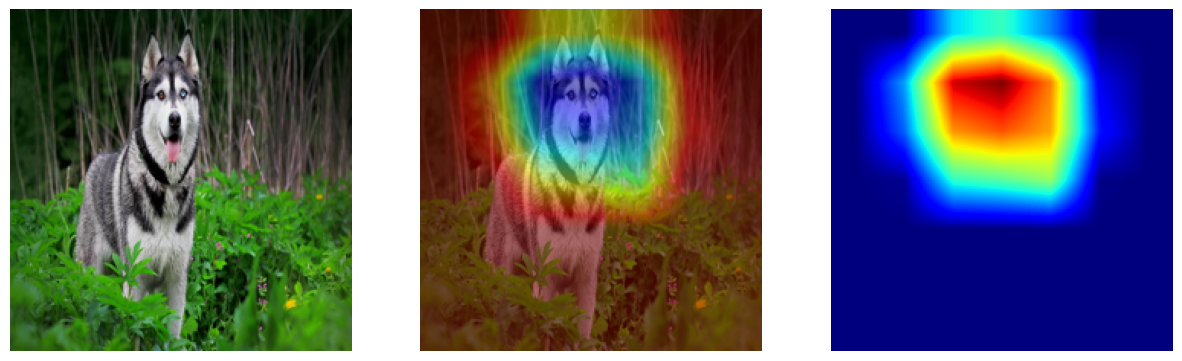

In [19]:
img = get_image_torch('images/husky.jpg', 224, 224)
cam_husky_our = get_scorecam(img, model, model.layer4[-1].conv3)
overlay_plot_torch(img, cam_husky_our, 0.5, 'images_prezentacja/scorecam_husky.png')

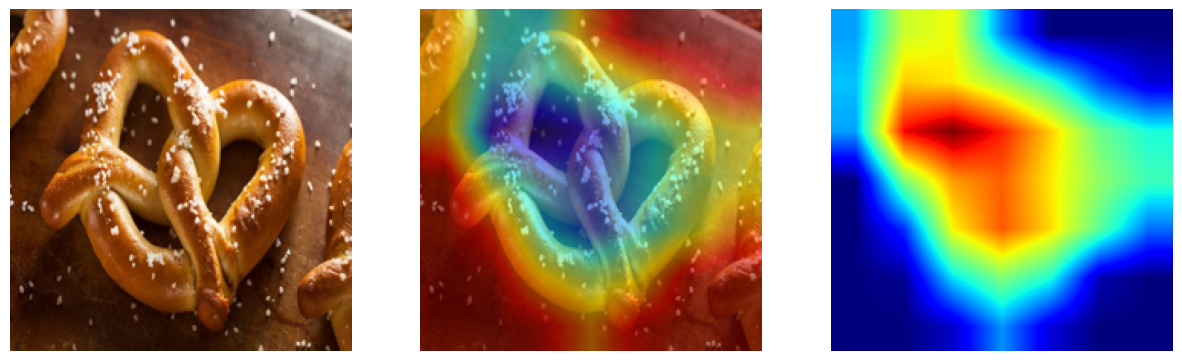

In [20]:
img = get_image_torch('images/precelek.jpg', 224, 224)
cam_pretzel_our = get_scorecam(img, model, model.layer4[-1].conv3)
overlay_plot_torch(img, cam_pretzel_our, 0.5, 'images_prezentacja/scorecam_precel.png')

In [21]:
from pytorch_grad_cam import GradCAM, HiResCAM, AblationCAM, ScoreCAM, GradCAMPlusPlus, XGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
from utils import *
from src import *

In [22]:
model = resnet50(pretrained=True)
target_layers = [model.layer4[-1].conv3]

100%|██████████| 128/128 [01:32<00:00,  1.38it/s]


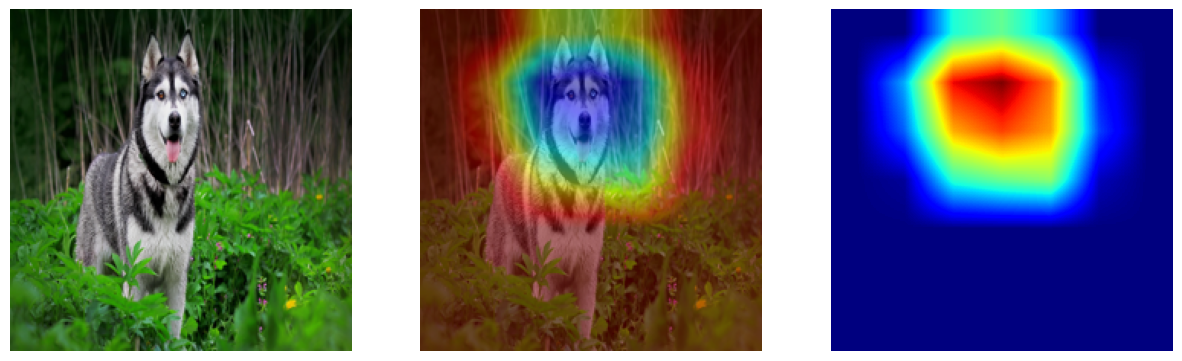

100%|██████████| 128/128 [01:30<00:00,  1.42it/s]


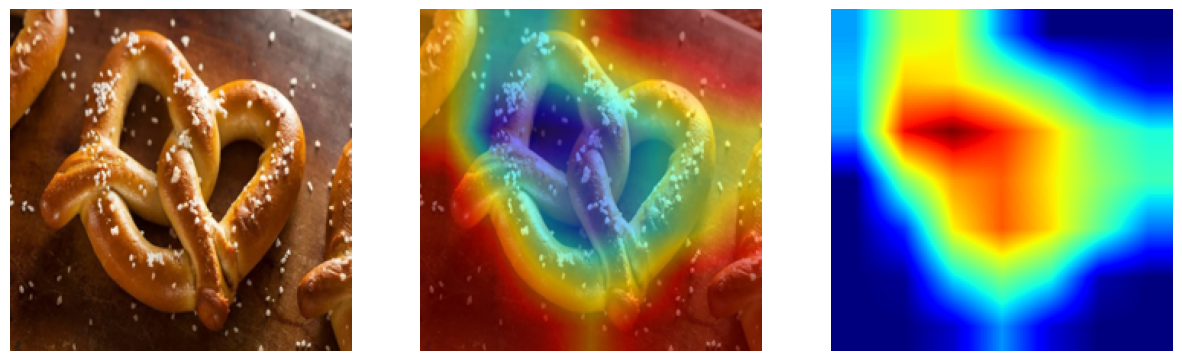

In [23]:
input_tensor = get_image_torch('images/husky.jpg', 224, 224).unsqueeze(0)
targets = [ClassifierOutputTarget(250)]

with ScoreCAM(model=model, target_layers=target_layers) as cam:
  cam_husky_lib = cam(input_tensor=input_tensor, targets=targets).squeeze(0)
overlay_plot_torch(input_tensor.squeeze(), cam_husky_lib, 0.5, 'images_prezentacja/scorecam_husky_lib.png')

input_tensor = get_image_torch('images/precelek.jpg', 224, 224).unsqueeze(0)
targets = [ClassifierOutputTarget(932)]

with ScoreCAM(model=model, target_layers=target_layers) as cam:
  cam_pretzel_lib = cam(input_tensor=input_tensor, targets=targets).squeeze(0)
overlay_plot_torch(input_tensor.squeeze(), cam_pretzel_lib, 0.5, 'images_prezentacja/scorecam_precel_lib.png')

In [24]:
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics.pairwise import cosine_similarity

def print_metrics(our, lib, x, y):
    our = our.copy()
    our = cv2.resize(our, (x, y))

    print(f'MSE: {np.mean((our - lib) ** 2)}')
    print(f'MAE: {np.mean(np.abs(our - lib))}')
    print(f'SSIM: {ssim(our, lib, data_range=1)}')
    print(f'Cosine similarity: {cosine_similarity(our.reshape(1, -1), lib.reshape(1, -1))}')

In [25]:
print_metrics(cam_husky_our, cam_husky_lib, 224, 224)

MSE: 0.09201662987470627
MAE: 0.16713377833366394
SSIM: 0.517584512269366
Cosine similarity: [[0.99896646]]


In [26]:
print_metrics(cam_pretzel_our, cam_pretzel_lib, 224, 224)

MSE: 0.19845843315124512
MAE: 0.3546699285507202
SSIM: 0.1544087332132771
Cosine similarity: [[0.99999946]]
